In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import cm
sns.set_style('ticks')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['pdb_data_seq.csv', 'pdb_data_no_dups.csv']


In [46]:
def precision_hesapla(class_id,TP, FP, TN, FN):
    sonuc=0
    
    for i in range(0,len(class_id)):
        if TP[i]==0 or FP[i]==0:
            TP[i]=0.00000000001
            FP[i]=0.00000000001
        sonuc+=(TP[i]/(TP[i]+FP[i]))
        
    sonuc=sonuc/len(class_id)
    return sonuc

def recall_hesapla(class_id,TP, FP, TN, FN):
    sonuc=0
    for i in range(0,len(class_id)):
        sonuc+=(TP[i]/(TP[i]+FN[i]))
       
    sonuc=sonuc/len(class_id)
    return sonuc
def accuracy_hesapla(class_id,TP, FP, TN, FN):
    sonuc=0
    for i in range(0,len(class_id)):
        sonuc+=((TP[i]+TN[i])/(TP[i]+FP[i]+TN[i]+FN[i]))
        
    sonuc=sonuc/len(class_id)
    return sonuc
def specificity_hesapla(class_id,TP, FP, TN, FN):
    sonuc=0
    for i in range(0,len(class_id)):
        sonuc+=(TN[i]/(FP[i]+TN[i]))
        
    sonuc=sonuc/len(class_id)
    return sonuc
def NPV_hesapla(class_id,TP, FP, TN, FN):
    sonuc=0
    for i in range(0,len(class_id)):
        sonuc+=(TN[i]/(TN[i]+FN[i]))
        
    sonuc=sonuc/len(class_id)
    return sonuc
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [47]:
def yenimetot(y_test,y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    y_test = label_binarize(y_test, classes=[0,1,2])
    y_score = label_binarize(y_score, classes=[0,1,2])
    n_classes = 3
    fpr = dict()
    tpr = dict()
    thr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc[2],fpr[2],tpr[2],thr[2]

In [48]:
df_dup = pd.read_csv('../input/pdb_data_no_dups.csv')
df_seq = pd.read_csv('../input/pdb_data_seq.csv')

In [49]:
df_merge = df_dup.merge(df_seq,how='inner',on='structureId')

In [50]:
len(df_dup.classification.unique().tolist())

5051

In [51]:
df_merge.rename({'macromoleculeType_x':'macromoleculeType','residueCount_y':'residueCount'},axis=1,inplace=True)
df_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)

In [52]:
df_isnull = pd.DataFrame(round((df_merge.isnull().sum().sort_values(ascending=False)/df_merge.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,crystallizationMethod,33.2
1,crystallizationTempK,32.6
2,phValue,27.7
3,pdbxDetails,18.2
4,densityMatthews,17.3
5,densityPercentSol,17.3
6,publicationYear,12.2
7,macromoleculeType,7.6
8,resolution,4.6
9,sequence,0


In [53]:
df_pub_year = df_merge.dropna(subset=['publicationYear']) #dropping the missing values from the publicationYear only
#graph
x1= df_pub_year.publicationYear.value_counts().sort_index().index
y1 = df_pub_year.publicationYear.value_counts().sort_index().values


In [54]:
# Transform the dataset
df_ph = df_merge.dropna(subset=['phValue']).copy()  # Copy to avoid SettingWithCopyWarning
df_ph.loc[:, 'pH_scale'] = df_ph['phValue'].apply(ph_scale)  # Safely add new column

# Graph
labels = df_ph['pH_scale'].value_counts().index
values = df_ph['pH_scale'].value_counts().values


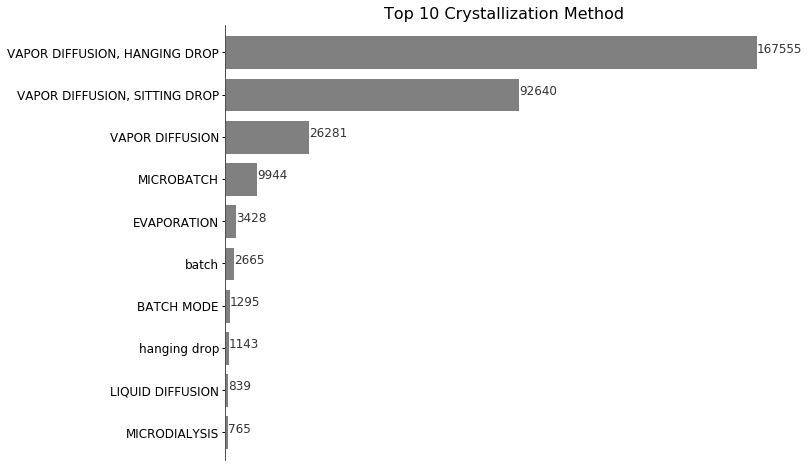

In [55]:
# The result of this cell Show the Top 10 most used crystallization method
df_cry_meth = df_merge.dropna(subset=['crystallizationMethod']) # this will drop all missing values in
#the crystallizationMethod column

cry_me = pd.DataFrame(df_cry_meth.crystallizationMethod.value_counts(ascending=False).head(10)).reset_index()
cry_me.columns = ['Crystallization Method','Values']

f,ax = plt.subplots(figsize=(10,8))
cry_me.plot(kind = 'barh',ax=ax,color='gray',legend=None,width= 0.8)
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2)), fontsize=12, color='black',alpha=0.8)  
#Set ylabel
ax.set_yticklabels(cry_me['Crystallization Method'])
# invert for largest on top 
ax.invert_yaxis()
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title ('Top 10 Crystallization Method',color='black',fontsize=16)
sns.despine(bottom=True)

In [56]:
popular_exp_tech = df_merge.experimentalTechnique.value_counts()[:3] # Extract the 3 top used Exp Tech 
popular_exp_tech_df = pd.DataFrame(popular_exp_tech).reset_index()
popular_exp_tech_df.columns=['Experimental Technique','values']
# ADDING A ROW FOR THE ORTHER EXPERIMENTAL TECHNIQUE USED. PLEASE PUT IN MIND THAT TO ORTHER TECHNIQUES 
#IS JUST A GROUP OF THE REST OF THECNIQUES USED
popular_exp_tech_df.loc[3]  = ['OTHER TECHNIQUE', 449]
print ('The X-RAY DIFFRACTION is by far the most used Experimental Technique during the Study of the Protein Sequences')

labels = popular_exp_tech_df['Experimental Technique']
values = popular_exp_tech_df['values']
a = 'Exp Tech'
 

The X-RAY DIFFRACTION is by far the most used Experimental Technique during the Study of the Protein Sequences


In [57]:
print ('There are more than 10 macro molecules used in this dataset but PROTEIN is widely used than the others')

ex = df_merge.macromoleculeType.value_counts()
a = 'Macro Mol Type'
colors = ['SlateGray','Orange','Green','DodgerBlue','DodgerBlue','DodgerBlue','DodgerBlue','DodgerBlue','DodgerBlue',
        'DodgerBlue','DodgerBlue','DodgerBlue','DodgerBlue']

There are more than 10 macro molecules used in this dataset but PROTEIN is widely used than the others


There are 4989 Unique Classification Types and the top 10 Classification type accounts for more than 50% of the classification in the dataset


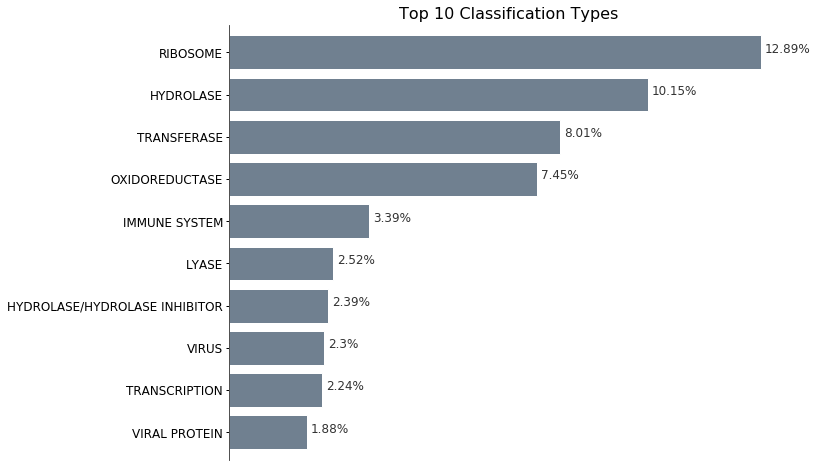

In [58]:
#classification distribution
clasific =df_merge.classification.value_counts(ascending=False)
df_class = pd.DataFrame(round(((clasific/df_merge.shape[0])*100),2).head(10)).reset_index()
df_class.columns = ['Classification', 'percent_value']
print('There are {} Unique Classification Types and the top 10 Classification type accounts for more than 50% of the classification in the dataset'.format(df_merge.classification.nunique()))
f,ax = plt.subplots(figsize=(10,8))

df_class.plot(kind = 'barh',ax=ax,color='slategray',legend=None,width= 0.8)
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2))+'%', fontsize=12, color='black',alpha=0.8)  
#Set ylabel
ax.set_yticklabels(df_class['Classification'])
# invert for largest on top 
ax.invert_yaxis()
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title ('Top 10 Classification Types',color='black',fontsize=16)
sns.despine(bottom=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



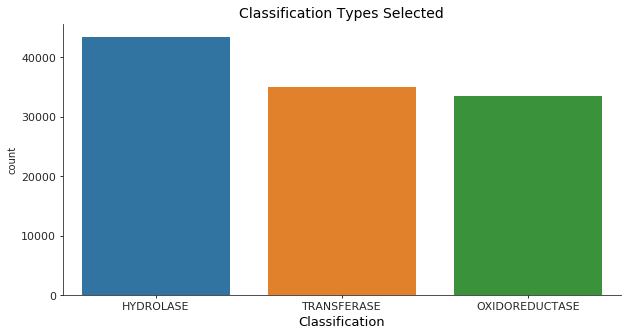

In [59]:
df_class.Classification.values.tolist()[1:4]
# Reduce the df_merge to df_protein which is compose of macromolecule type [Protein and Protein#RNA]
macrotype = ['Protein','Protein#RNA']
df_protein = df_merge[(df_merge['experimentalTechnique'] =='X-RAY DIFFRACTION') & 
                      (df_merge['macromoleculeType'].isin(macrotype))&
                     (df_merge['classification'].isin(df_class.Classification.values.tolist()[1:4]))]

df_protein.reset_index(drop=True,inplace=True)
columns = ['crystallizationMethod' ,'pdbxDetails', 'publicationYear','phValue','crystallizationTempK']
#Dropping columns with missing value above 15%
df_protein.drop(columns=columns,inplace=True)
# Classification Type that will be used from now on
f,ax= plt.subplots(figsize=(10,5))
sns.countplot('classification',data=df_protein, ax=ax)
ax.set_title('Classification Types Selected',fontsize=14,color='black')
ax.tick_params(length =3,labelsize=11,color='black')
ax.set_xlabel('Classification',color='black',fontsize=13)
sns.despine()

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in greater

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in less



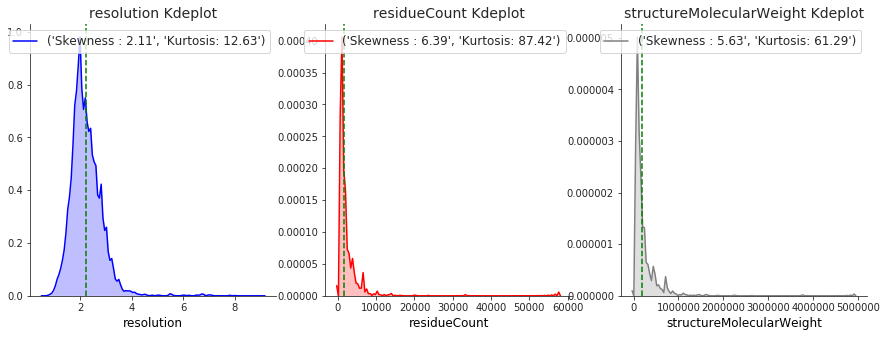

In [60]:
from scipy import stats
from scipy.stats import norm, skew, kurtosis
def stat_kde_plot(input1,input2,input3):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    sns.kdeplot(df_protein[input1],ax = ax1,color ='blue',shade=True,
                label=("Skewness : %.2f"%(df_protein[input1].skew()),
                       "Kurtosis: %.2f"%(df_protein[input1].kurtosis())))
    sns.kdeplot(df_protein[input2], ax = ax2,color='r',shade=True,
                label=("Skewness : %.2f"%(df_protein[input2].skew()),
                       "Kurtosis: %.2f"%(df_protein[input2].kurtosis())))
    sns.kdeplot(df_protein[input3], ax = ax3,color='gray',shade=True,
                label=("Skewness : %.2f"%(df_protein[input3].skew()),
                       "Kurtosis: %.2f"%(df_protein[input3].kurtosis())))
    axes = [ax1,ax2,ax3]
    input = [input1,input2,input3]
    for j in range(len(axes)):
        axes[j].set_xlabel(input[j],color='black',fontsize=12)
        axes[j].set_title(input[j] + ' Kdeplot',fontsize=14)
        axes[j].axvline(df_protein[input[j]].mean() , color ='g',linestyle = '--')
        axes[j].legend(loc ='upper right',fontsize=12,ncol=2)
    sns.despine()
    return plt.show()

stat_kde_plot('resolution','residueCount','structureMolecularWeight')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



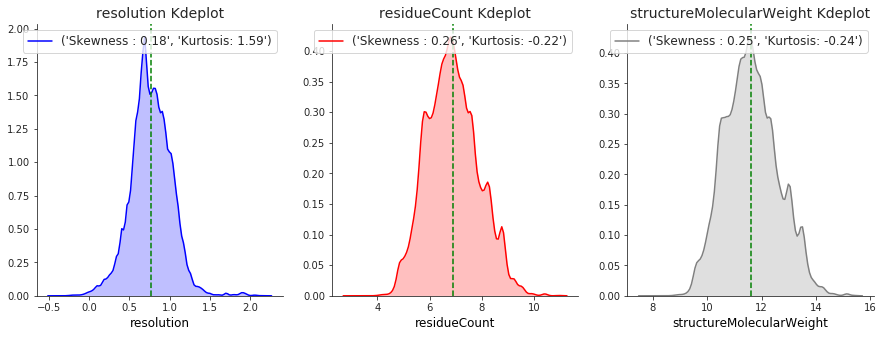

In [61]:
for i in ['resolution','residueCount','structureMolecularWeight']:
    df_protein[i] = df_protein[i].map(lambda i: np.log(i) if i > 0 else 0)
stat_kde_plot('resolution','residueCount','structureMolecularWeight')

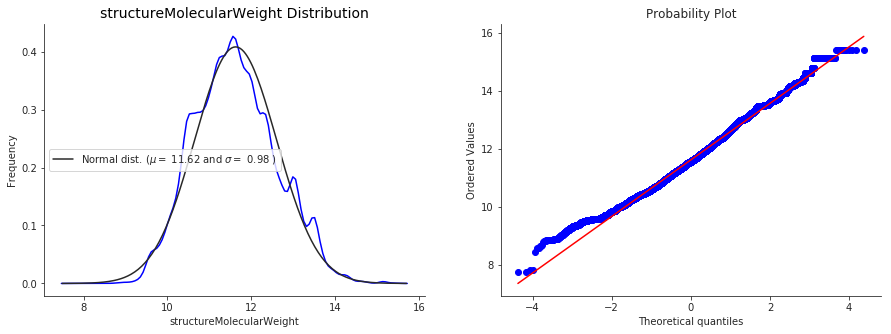

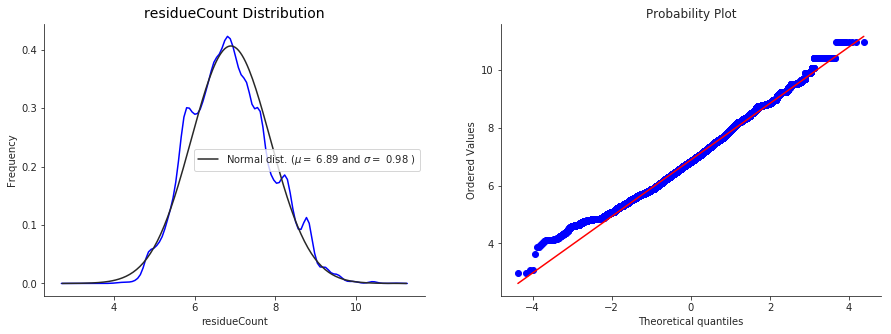

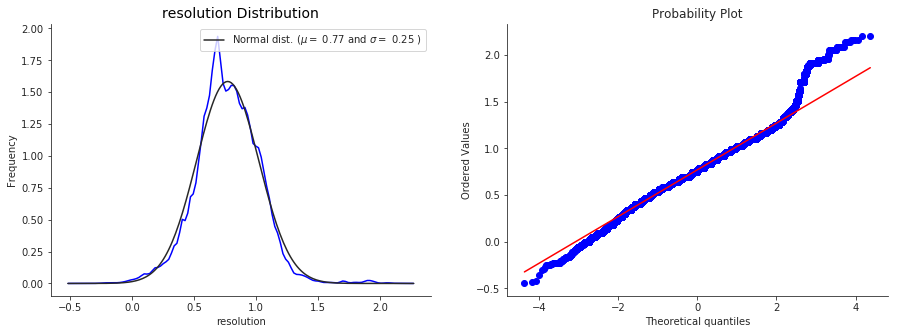

In [62]:
# Drop all null values from this columns
def stat_plot (input):
    (mu, sigma) = norm.fit(df_protein[input])
    f, (ax1, ax2)= plt.subplots(1,2,figsize=(15,5))
    # Apply the log transformation on the column
    sns.distplot(df_protein[input],ax = ax1,fit=norm,color ='blue',hist=False)
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    ax1.set_ylabel('Frequency')
    ax1.set_title(input +' Distribution',color='black',fontsize=14)
    #Get also the QQ-plot
    res = stats.probplot(df_protein[input], plot=ax2)
    sns.despine()
    return plt.show()
stat_plot('structureMolecularWeight')
stat_plot('residueCount')
stat_plot('resolution')

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



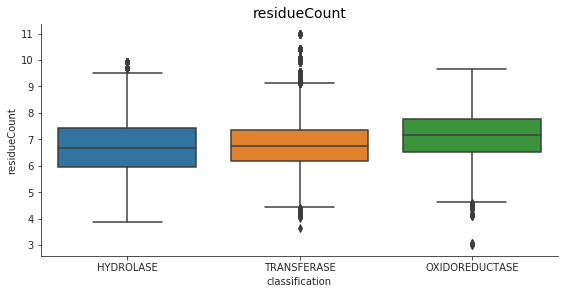

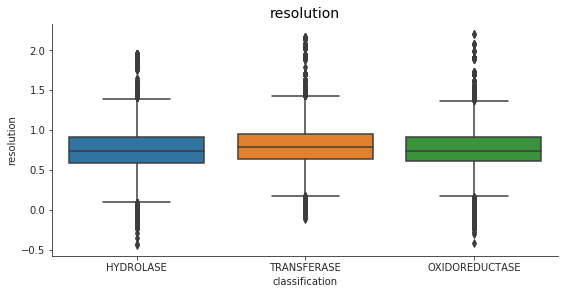

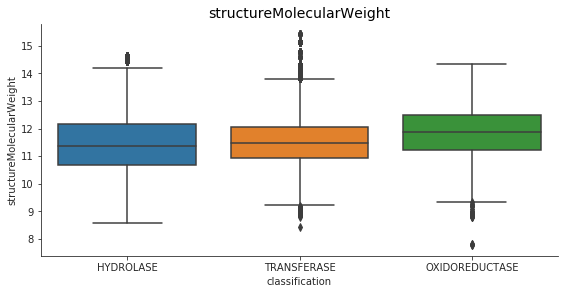

In [63]:
def box_plot(input):
    g = sns.factorplot(x="classification", y = input,data = df_protein, kind="box",size =4,
                  aspect=2)
    plt.title(input, fontsize=14,color='black')
    return plt.show()

box_plot('residueCount')
box_plot('resolution')
box_plot('structureMolecularWeight')

In [64]:
#class_dict = {'RIBOSOME':1,'HYDROLASE':2,'TRANSFERASE':3} 
class_dict = {'HYDROLASE':1,'TRANSFERASE':2,'OXIDOREDUCTASE':3}
df_protein['class'] = df_protein.classification.map(class_dict)
#Reduce the dataset to only numerical column and clssification column
columns = ['resolution','structureMolecularWeight','densityMatthews','densityPercentSol',
           'residueCount','class']
df_ml = df_protein[columns]
df_ml.dropna(inplace=True)
df_ml.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,residueCount,class
0,0.765468,11.085264,2.71,54.69,6.349139,1
1,0.765468,11.085264,2.71,54.69,6.349139,1
2,0.722706,10.264662,2.48,50.36,5.513429,1
3,0.722706,10.264662,2.48,50.36,5.513429,1
4,0.641854,10.321915,2.40,48.68,5.513429,1


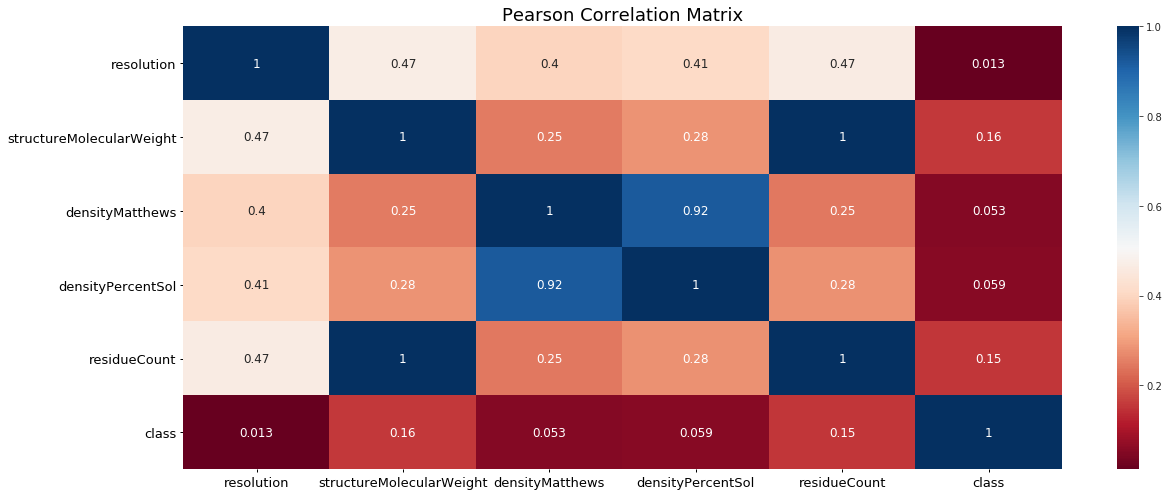

In [65]:
colormap = plt.cm.RdBu
f, ax = plt.subplots(figsize=(18,7))
sns.heatmap(df_ml.corr(),cmap= colormap,annot=True,ax=ax,annot_kws ={'fontsize':12})
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':13}
ax.tick_params(**kwargs)
ax.tick_params(**kwargs,axis='x')
plt.title ('Pearson Correlation Matrix', color = 'black',fontsize=18)
plt.tight_layout()
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df_ml.drop('class',axis = 1)
y = df_ml['class']

In [67]:
y=y.values

In [68]:
type(y)

numpy.ndarray

In [69]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardizing the dataset
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [70]:
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

In [71]:
score_liste=[]
auc_scor=[]
precision_scor=[]
recall_scor=[]
f1_scor=[]
LR_plus=[]
LR_eksi=[]
odd_scor=[]
NPV_scor=[]
youden_scor=[]
specificity_scor=[]
from sklearn.neighbors import KNeighborsClassifier

In [72]:
from sklearn.metrics import roc_curve


KNN Algoritması başarım sonucu:  0.6519669480869409


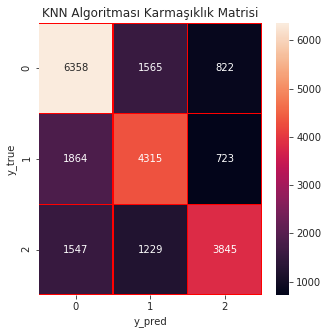

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



KNN algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.65      0.73      0.69      8745
           2       0.61      0.63      0.62      6902
           3       0.71      0.58      0.64      6621

    accuracy                           0.65     22268
   macro avg       0.66      0.64      0.65     22268
weighted avg       0.66      0.65      0.65     22268



In [73]:
k=11
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(x_train,y_train)
y_head=knn.predict(x_test)
print("KNN Algoritması başarım sonucu: ",knn.score(x_test,y_test))

from sklearn.metrics import confusion_matrix
cmknn = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmknn,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("KNN Algoritması Karmaşıklık Matrisi")
plt.show()
knnauc,knn_fpr,knn_tpr,knn_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(knnauc)
#knn_fpr,knn_tpr,knn_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))

LR_plus.append((recall_hesapla(classid,tn,fp,fn,tp)/(1-specificity_hesapla(classid,tn,fp,fn,tp))))
LR_eksi.append(((1-recall_hesapla(classid,tn,fp,fn,tp))/specificity_hesapla(classid,tn,fp,fn,tp)))
odd_scor.append(((recall_hesapla(classid,tn,fp,fn,tp)/(1-specificity_hesapla(classid,tn,fp,fn,tp))))/(((1-recall_hesapla(classid,tn,fp,fn,tp))/specificity_hesapla(classid,tn,fp,fn,tp))))
youden_scor.append((recall_hesapla(classid,tn,fp,fn,tp)+specificity_hesapla(classid,tn,fp,fn,tp)-1))
print("KNN algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

Karar Ağaçları Algoritması için başarım sonucu:  0.912385485899048
DTC algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.92      0.91      0.91      8745
           2       0.89      0.91      0.90      6902
           3       0.93      0.92      0.92      6621

    accuracy                           0.91     22268
   macro avg       0.91      0.91      0.91     22268
weighted avg       0.91      0.91      0.91     22268



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



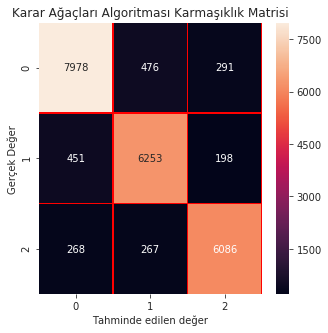

In [74]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_head=dtc.predict(x_test)
print("Karar Ağaçları Algoritması için başarım sonucu: ",dtc.score(x_test,y_test))
dtcauc,dtc_fpr,dtc_tpr,dtc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(dtcauc)
#dtc_fpr,dtc_tpr,dtc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)

print("DTC algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmdtc = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmdtc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahminde edilen değer")
plt.ylabel("Gerçek Değer")
plt.title("Karar Ağaçları Algoritması Karmaşıklık Matrisi")
plt.show()

Rastgele Orman Algoritması başarım sonucu:  0.9268906053529729
Rastgele Orman algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.91      0.94      0.93      8745
           2       0.92      0.92      0.92      6902
           3       0.96      0.92      0.94      6621

    accuracy                           0.93     22268
   macro avg       0.93      0.93      0.93     22268
weighted avg       0.93      0.93      0.93     22268



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



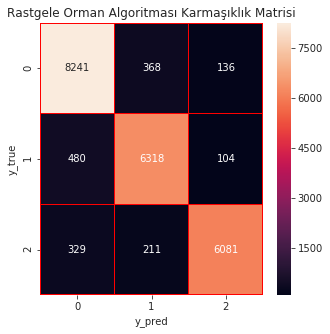

In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=225,random_state=1)
rfc.fit(x_train,y_train)
y_head=rfc.predict(x_test)
print("Rastgele Orman Algoritması başarım sonucu: ",rfc.score(x_test,y_test))
rfcauc,rfc_fpr,rfc_tpr,rfc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(rfcauc)
#rfc_fpr,rfc_tpr,rfc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("Rastgele Orman algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmrfc = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmrfc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Rastgele Orman Algoritması Karmaşıklık Matrisi")
plt.show()

Naive Bayes Algoritması başarım sonucu:  0.42783366265493084
Naive Bayes algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.47      0.48      0.47      8745
           2       0.41      0.30      0.35      6902
           3       0.40      0.49      0.44      6621

    accuracy                           0.43     22268
   macro avg       0.42      0.42      0.42     22268
weighted avg       0.43      0.43      0.42     22268



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



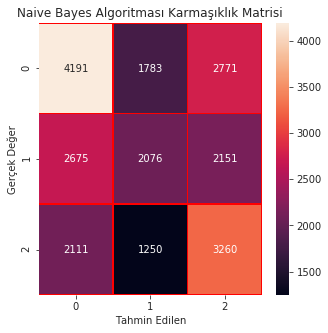

In [76]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(x_train,y_train)
y_head=nb.predict(x_test)
print("Naive Bayes Algoritması başarım sonucu: ",nb.score(x_test,y_test))

nbauc,nb_fpr,nb_tpr,nb_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(nbauc)
#nb_fpr,nb_tpr,nb_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("Naive Bayes algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmnb = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmnb,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Naive Bayes Algoritması Karmaşıklık Matrisi")
plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Logistic Regresyon Algoritması başarım sonucu:  0.4241063409376684


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Lojistik Regresyon algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.42      0.64      0.51      8745
           2       0.43      0.24      0.31      6902
           3       0.42      0.34      0.37      6621

    accuracy                           0.42     22268
   macro avg       0.43      0.40      0.40     22268
weighted avg       0.43      0.42      0.41     22268



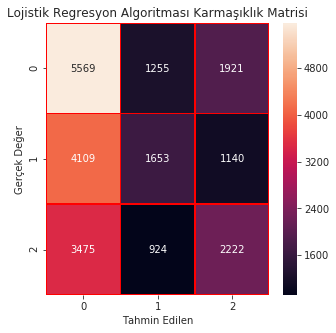

In [77]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
y_head=lr.predict(x_test)
print("Logistic Regresyon Algoritması başarım sonucu: ",lr.score(x_test,y_test))

lrcauc,lrc_fpr,lrc_tpr,lrc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(lrcauc)
#lrc_fpr,lrc_tpr,lrc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("Lojistik Regresyon algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmlr = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmlr,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Lojistik Regresyon Algoritması Karmaşıklık Matrisi")
plt.show()

Destek Vektör Makineleri Algoritması başarım sonucu:  0.4728758756960661
Destek Vektör Makineleri algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.50      0.53      0.52      8745
           2       0.43      0.47      0.45      6902
           3       0.48      0.40      0.44      6621

    accuracy                           0.47     22268
   macro avg       0.47      0.47      0.47     22268
weighted avg       0.47      0.47      0.47     22268



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



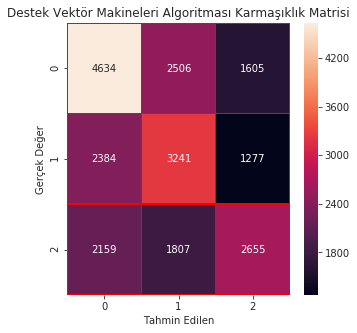

In [78]:
from sklearn.svm import SVC
svc=SVC(random_state=1)
svc.fit(x_train,y_train)
y_head=svc.predict(x_test)
print("Destek Vektör Makineleri Algoritması başarım sonucu: ",svc.score(x_test,y_test))

svcauc,svc_fpr,svc_tpr,svc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(svcauc)
#svc_fpr,svc_tpr,svc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("Destek Vektör Makineleri algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmsvc = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmsvc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Destek Vektör Makineleri Algoritması Karmaşıklık Matrisi")
plt.show()

In [79]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

Gradient Boosting Classifier Algoritması başarım sonucu:  0.6071941799892222
Gradient Boosting Classifier algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.62      0.67      0.64      8745
           2       0.55      0.59      0.57      6902
           3       0.67      0.54      0.60      6621

    accuracy                           0.61     22268
   macro avg       0.61      0.60      0.60     22268
weighted avg       0.61      0.61      0.61     22268



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



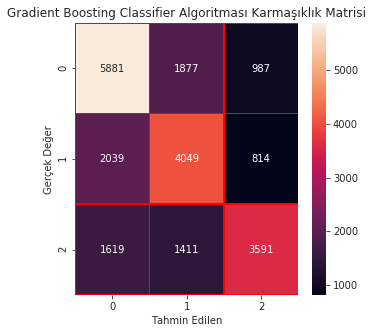

In [80]:
gfc=GradientBoostingClassifier(n_estimators= 1000, max_leaf_nodes= 4, max_depth=None,random_state= 2,min_samples_split= 5)
gfc.fit(x_train,y_train)
y_head=gfc.predict(x_test)
print("Gradient Boosting Classifier Algoritması başarım sonucu: ",gfc.score(x_test,y_test))
gfcauc,gfc_fpr,gfc_tpr,gfc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(gfcauc)
#gfc_fpr,gfc_tpr,gfc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("Gradient Boosting Classifier algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmgfc = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmgfc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Gradient Boosting Classifier Algoritması Karmaşıklık Matrisi")
plt.show()

AdaBoosting Classifier Algoritması başarım sonucu:  0.47574995509250945


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



AdaBoosting Classifier algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.53      0.50      0.51      8745
           2       0.43      0.44      0.44      6902
           3       0.46      0.49      0.47      6621

    accuracy                           0.48     22268
   macro avg       0.47      0.47      0.47     22268
weighted avg       0.48      0.48      0.48     22268



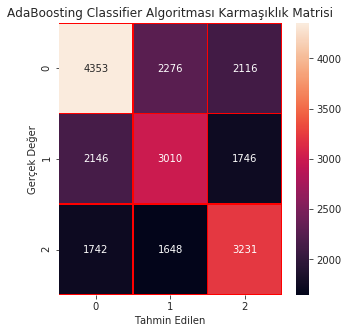

In [81]:
abc=AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(x_train,y_train)
y_head=abc.predict(x_test)
print("AdaBoosting Classifier Algoritması başarım sonucu: ",abc.score(x_test,y_test))

abcauc,abc_fpr,abc_tpr,abc_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(abcauc)
#abc_fpr,abc_tpr,abc_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("AdaBoosting Classifier algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmabc = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmabc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("AdaBoosting Classifier Algoritması Karmaşıklık Matrisi")
plt.show()

Yapay Sinir Ağları Algoritması başarım sonucu:  0.4374438656367882


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



AdaBoosting Classifier algoritması için sınıflandırma raporu: 
               precision    recall  f1-score   support

           1       0.48      0.49      0.49      8745
           2       0.40      0.33      0.36      6902
           3       0.42      0.48      0.45      6621

    accuracy                           0.44     22268
   macro avg       0.43      0.43      0.43     22268
weighted avg       0.44      0.44      0.43     22268



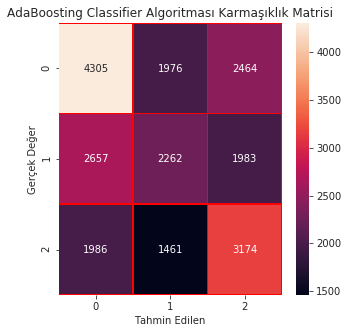

In [82]:
ysa=MLPClassifier(alpha=1, max_iter=1000)
ysa.fit(x_train,y_train)
y_head=ysa.predict(x_test)
print("Yapay Sinir Ağları Algoritması başarım sonucu: ",ysa.score(x_test,y_test))

ysaauc,ysa_fpr,ysa_tpr,ysa_trr=yenimetot(y_test,y_head)
classid,tn,fp,fn,tp=perf_measure(y_test,y_head)
auc_scor.append(ysaauc)
#ysa_fpr,ysa_tpr,ysa_trr=roc_curve(y_test,y_head)
score_liste.append(accuracy_hesapla(classid,tn,fp,fn,tp))
precision_scor.append(precision_hesapla(classid,tn,fp,fn,tp))
recall_scor.append(recall_hesapla(classid,tn,fp,fn,tp))
f1_scor.append(f1_score(y_test,y_head,average='macro'))
NPV_scor.append(NPV_hesapla(classid,tn,fp,fn,tp))
specificity_scor.append(specificity_hesapla(classid,tn,fp,fn,tp))
TPR=recall_hesapla(classid,tn,fp,fn,tp)
TNR=specificity_hesapla(classid,tn,fp,fn,tp)
FPR=1-TNR
if FPR==0:
    FPR=0.00001
FNR=1-TPR
lreksi=FNR/TNR
lrarti=TPR/FPR
if lreksi==0:
    lreksi=0.00000001
LR_plus.append(TPR/FPR)
LR_eksi.append(FNR/TNR)
odd_scor.append(lrarti/lreksi)
youden_scor.append(TPR+TNR-1)
print("AdaBoosting Classifier algoritması için sınıflandırma raporu: \n",classification_report(y_test,y_head))

cmysa = confusion_matrix(y_test,y_head)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cmysa,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("AdaBoosting Classifier Algoritması Karmaşıklık Matrisi")
plt.show()

In [83]:
algo_liste=["KNN","Decision Tree","Random Forest","Naive Bayes","Linear Regression","Support Vector Machine","Gradient Boosting Classifier","AdaBoosting Classifier","Neural Network"]
score={"algo_list":algo_liste,"score_liste":score_liste,"precision":precision_scor,"recall":recall_scor,"f1_score":f1_scor,"AUC":auc_scor,"LR+":LR_plus,"LR-":LR_eksi,"ODD":odd_scor,"YOUDEN":youden_scor,"Specificity":specificity_scor}

In [84]:
df=pd.DataFrame(score)
df

,algo_list,score_liste,precision,recall,f1_score,AUC,LR+,LR-,ODD,YOUDEN,Specificity
0,KNN,0.651967,0.657056,0.480796,0.647674,0.721676,2.267144,0.658948,3.440553,0.268725,0.787929
1,Decision Tree,0.912385,0.912251,0.836877,0.912349,0.928808,18.132385,0.171016,106.027200,0.790723,0.953846
2,Random Forest,0.926891,0.929563,0.860459,0.927222,0.938853,22.191160,0.145170,152.863006,0.821684,0.961225
3,Naive Bayes,0.427834,0.423879,0.271824,0.419702,0.551699,0.678416,1.214993,0.558370,-0.128851,0.599325
4,Linear Regression,0.424106,0.425121,0.278343,0.396648,0.548845,0.708812,1.188284,0.596500,-0.114347,0.607310
5,Support Vector Machine,0.472876,0.471168,0.308754,0.467425,0.594445,0.861750,1.077189,0.799999,-0.049533,0.641713
6,Gradient Boosting Classifier,0.607194,0.611456,0.434250,0.603289,0.686331,1.772498,0.749331,2.365441,0.189257,0.755007
7,AdaBoosting Classifier,0.475750,0.472608,0.310307,0.472945,0.590368,0.870928,1.071442,0.812856,-0.045987,0.643706
8,Neural Network,0.437444,0.431502,0.278160,0.430459,0.552028,0.707619,1.189374,0.594951,-0.114933,0.606907


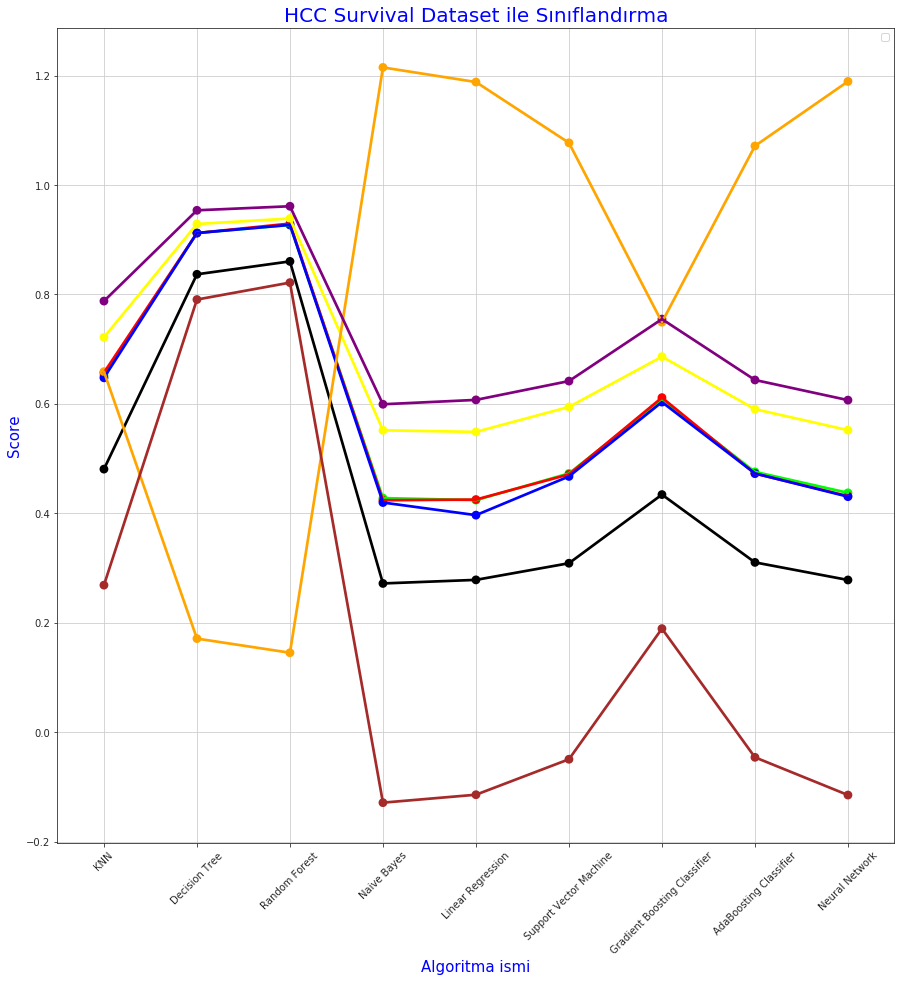

In [85]:
f,ax1 = plt.subplots(figsize =(15,15))
sns.pointplot(x=df['algo_list'], y=df['score_liste'],data=df,color='lime',alpha=0.8,label="score_liste")
sns.pointplot(x=df['algo_list'], y=df['precision'],data=df,color='red',alpha=0.8,label="precision")
sns.pointplot(x=df['algo_list'], y=df['recall'],data=df,color='black',alpha=0.8,label="recall")
sns.pointplot(x=df['algo_list'], y=df['f1_score'],data=df,color='blue',alpha=0.8,label="f1_score")
sns.pointplot(x=df['algo_list'], y=df['AUC'],data=df,color='yellow',alpha=0.8,label="AUC")

sns.pointplot(x=df['algo_list'], y=df['LR-'],data=df,color='orange',alpha=0.8,label="YOUDEN")

sns.pointplot(x=df['algo_list'], y=df['YOUDEN'],data=df,color='brown',alpha=0.8,label="LR-")
sns.pointplot(x=df['algo_list'], y=df['Specificity'],data=df,color='purple',alpha=0.8,label="Specificity")
plt.xlabel('Algoritma ismi',fontsize = 15,color='blue')
plt.ylabel('Score',fontsize = 15,color='blue')
plt.xticks(rotation= 45)
plt.title('HCC Survival Dataset ile Sınıflandırma',fontsize = 20,color='blue')
plt.grid()
plt.legend()
plt.show()

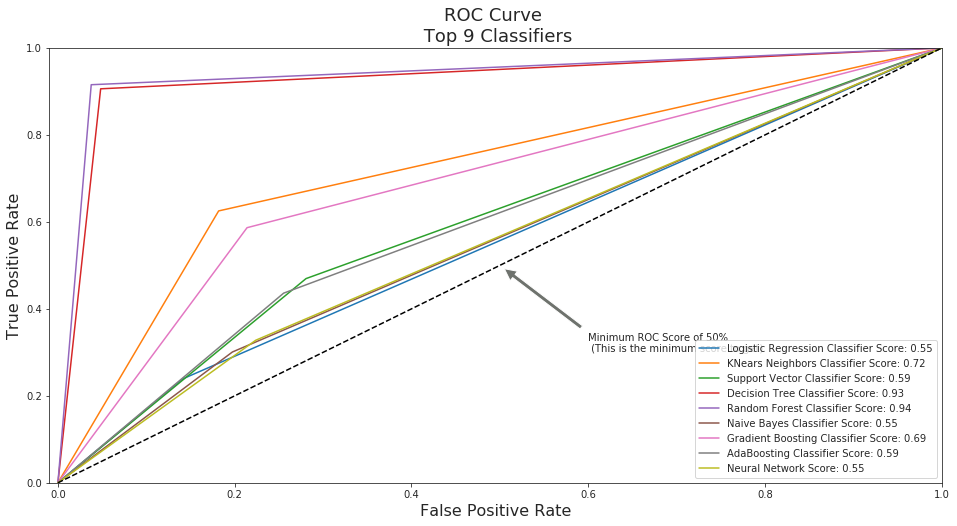

In [86]:
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr,rfc_fpr,rfc_tpr,nb_fpr,nb_tpr,gbc_fpr,gbc_tpr,abc_fpr,abc_tpr,ysa_fpr,ysa_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 9 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: %0.2f'% lrcauc)
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: %0.2f'% knnauc)
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: %0.2f'% svcauc)
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: %0.2f'% dtcauc)
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: %0.2f'% rfcauc)
    plt.plot(nb_fpr, nb_tpr, label='Naive Bayes Classifier Score: %0.2f'% nbauc)
    plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier Score: %0.2f'% gfcauc)
    plt.plot(abc_fpr, abc_tpr, label='AdaBoosting Classifier Score: %0.2f'% abcauc)
    plt.plot(ysa_fpr, ysa_tpr, label='Neural Network Score: %0.2f'% ysaauc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(lrc_fpr, lrc_tpr, knn_fpr, knn_tpr, svc_fpr, svc_tpr, dtc_fpr, dtc_tpr,rfc_fpr,rfc_tpr,nb_fpr,nb_tpr,gfc_fpr,gfc_tpr,abc_fpr,abc_tpr,ysa_fpr,ysa_tpr)
plt.show()